# 데이터셋 불러오기

In [1]:
import netCDF4 as nc

path = r'C:\Users\kyuji\.vscode\Language\Python\.vscode\MLWP\data\0801\l015_v070_erlo_unis_20kind.2024080100.nc'
# ncdata = nc.Dataset(path)
# print(ncdata)

import xarray as xr
ds = xr.open_dataset(path, engine='netcdf4')
# ds

In [11]:
xr.set_options(display_values_threshold=10, display_max_rows=30)

print(ds)  # 전체 데이터셋의 구조를 간략히 출력
print(ds.dims)  # 차원 정보 출력
print(ds.coords)  # 좌표 정보 출력
print(ds.variables)  # 변수 정보 출력

<xarray.Dataset> Size: 2GB
Dimensions:                                          (y: 781, x: 602, time: 49)
Coordinates:
  * y                                                (y) float64 6kB 0.0 ... ...
  * x                                                (x) float64 5kB 0.0 ... ...
    latitude                                         (y, x) float64 4MB 32.26...
    longitude                                        (y, x) float64 4MB 121.8...
  * time                                             (time) datetime64[ns] 392B ...
Data variables:
    NDNSW_surface                                    (time, y, x) float32 92MB ...
    NCPCP_surface                                    (time, y, x) float32 92MB ...
    SNOL_surface                                     (time, y, x) float32 92MB ...
    UGRD_10maboveground                              (time, y, x) float32 92MB ...
    VGRD_10maboveground                              (time, y, x) float32 92MB ...
    TMP_1_5maboveground                  

In [12]:
from datetime import datetime, timedelta

def convert_kst_to_utc(kst_time_str):
    """
    한국 시간(KST)을 UTC로 변환하는 함수
    
    Parameters:
    kst_time_str (str): 변환할 한국 시간 (예: '2024-09-30 16:00:00')
    
    Returns:
    str: UTC로 변환된 시간 (예: '2024-09-30T07:00:00')
    """
    # 문자열을 datetime 객체로 변환 (입력 형식: 'YYYY-MM-DD HH:MM:SS')
    kst_time = datetime.strptime(kst_time_str, '%Y-%m-%d %H:%M:%S')
    
    # 9시간을 빼서 UTC로 변환
    utc_time = kst_time - timedelta(hours=9)
    
    # 문자열 형식으로 변환하여 반환 (출력 형식: 'YYYY-MM-DDTHH:MM:SS')
    return utc_time.strftime('%Y-%m-%dT%H:%M:%S')

# 함수 사용 예시
kst_time_str = '2024-09-30 16:00:00'
utc_time_str = convert_kst_to_utc(kst_time_str)
print(utc_time_str)  # '2024-09-30T07:00:00' 출력

2024-09-30T07:00:00


In [13]:
from datetime import datetime, timedelta

def convert_utc_to_kst(utc_time_str):
    """
    UTC 시간을 KST(한국 표준시)로 변환하는 함수
    
    Parameters:
    utc_time_str (str): 변환할 UTC 시간 (예: '2024-10-02T06:00:00')
    
    Returns:
    str: KST로 변환된 시간 (예: '2024-10-02 15:00:00')
    """
    # 문자열을 datetime 객체로 변환
    utc_time = datetime.strptime(utc_time_str, '%Y-%m-%dT%H:%M:%S')
    
    # 9시간을 더해 한국 표준시(KST)로 변환
    kst_time = utc_time + timedelta(hours=9)
    
    # 문자열 형식으로 변환하여 반환 (출력 형식: 'YYYY-MM-DD HH:MM:SS')
    return kst_time.strftime('%Y-%m-%d %H:%M:%S')

# 함수 사용 예시
utc_time_str = '2024-10-02T06:00:00'
kst_time_str = convert_utc_to_kst(utc_time_str)
print(kst_time_str)  # '2024-10-02 15:00:00' 출력

2024-10-02 15:00:00


# 특정 온도 이상인 지역 표시

C:\Users\kyuji\AppData\Local\Temp\ipykernel_10704\2082291953.py:39: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  map_plot = ax.pcolormesh(lon, lat, high_temp_count, cmap='Reds')


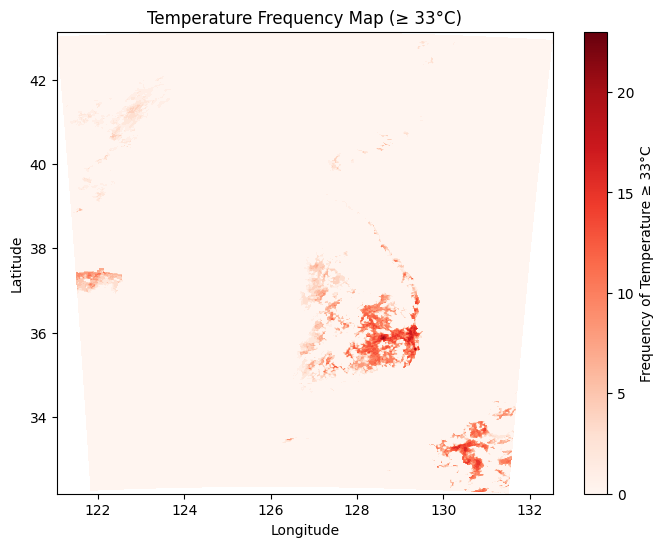

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_temp_frequency_map(ds, start_time, end_time, temp_threshold_celsius):
    """
    주어진 시간 범위 내에서 각 좌표의 TMP_1_5maboveground 값이 특정 섭씨 온도 이상인 시간의 빈도를 지도 형태로 시각화하는 함수
    
    Parameters:
    ds (xarray.Dataset): 기후 데이터셋
    start_time (str): 시작 시간 (예: '2024-10-01T00:00:00')
    end_time (str): 종료 시간 (예: '2024-10-03T00:00:00')
    temp_threshold_celsius (float): 섭씨 온도 임계값
    
    Returns:
    None: 온도 빈도를 지도 형태로 시각화
    """
    # 1. 섭씨 온도를 켈빈으로 변환
    temp_threshold_kelvin = temp_threshold_celsius + 273.15
    
    # 2. 시간 범위 내의 데이터 필터링
    time_filtered_ds = ds.sel(time=slice(start_time, end_time))
    
    # 3. TMP_1_5maboveground에서 온도 임계값 이상인 시간 필터링
    temp_data = time_filtered_ds['TMP_1_5maboveground']
    
    # 특정 온도 이상인 시간대 확인 (True/False mask)
    high_temp_mask = temp_data >= temp_threshold_kelvin
    
    # 4. 각 (y, x) 좌표에서 해당 조건을 만족하는 시간의 개수 계산
    high_temp_count = high_temp_mask.sum(dim='time')
    
    # 5. 경도와 위도 데이터 가져오기
    lat = ds['latitude'][:].data
    lon = ds['longitude'][:].data
    
    # 6. 지도 시각화
    fig, ax = plt.subplots(figsize=(8, 6))
    # pcolormesh는 그리드 데이터 시각화에 적합한 함수
    map_plot = ax.pcolormesh(lon, lat, high_temp_count, cmap='Reds')
    
    # 컬러바 추가
    cbar = fig.colorbar(map_plot, ax=ax)
    cbar.set_label(f'Frequency of Temperature ≥ {temp_threshold_celsius}°C')

    # 그래프 제목 및 축 설정
    ax.set_title(f'Temperature Frequency Map (≥ {temp_threshold_celsius}°C)')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
    plt.show()

# 함수 사용 예시
visualize_temp_frequency_map(ds, '2024-08-01T00:00:00', '2024-08-03T00:00:00', 33)  # 섭씨 33도 이상인 빈도를 지도에 표시

# 임의의 위도 경도와 가장 가까운 지점 찾기

In [8]:
# 관측소 번호로 위도와 경도를 가져오기
obs_lat_lon = {105: {'latitude': 37.75147, 'longitude': 128.89099, 'region': '강릉'}, 98: {'latitude': 37.90188, 'longitude': 127.0607, 'region': '동두천'},
                294: {'latitude': 34.88818, 'longitude': 128.60459, 'region': '거제'}, 283: {'latitude': 35.81747, 'longitude': 129.20123, 'region': '경주시'},
                156: {'latitude': 35.17294, 'longitude': 126.89156, 'region': '광주'}, 143: {'latitude': 35.87797, 'longitude': 128.65296, 'region': '대구'},
                133: {'latitude': 36.37199, 'longitude': 127.3721, 'region': '대전'}, 159: {'latitude': 35.10468, 'longitude': 129.03203, 'region': '부산'},
                108: {'latitude': 37.57142, 'longitude': 126.9658, 'region': '서울'}, 239: {'latitude': 36.48522, 'longitude': 127.24438, 'region': '세종'},
                152: {'latitude': 35.58237, 'longitude': 129.33469, 'region': '울산'}, 112: {'latitude': 37.47772, 'longitude': 126.6249, 'region': '인천'},
                259: {'latitude': 34.64464, 'longitude': 126.78405, 'region': '강진군'}, 172: {'latitude': 35.34824, 'longitude': 126.599, 'region': '고창'},
                184: {'latitude': 33.51411, 'longitude': 126.52969, 'region': '제주'}, 238: {'latitude': 36.10565, 'longitude': 127.48185, 'region': '금산'},
                226: {'latitude': 36.48761, 'longitude': 127.73415, 'region': '보은'}}

In [9]:
import numpy as np

def find_nearest_xy(lat_data, lon_data, target_lat, target_lon):
    """
    유클리드 거리를 이용해 임의의 위도와 경도를 입력받아 가장 가까운 좌표 (x, y)를 찾는 함수
    
    Parameters:
    lat_data (np.array): 데이터셋의 위도 배열 (2D array)
    lon_data (np.array): 데이터셋의 경도 배열 (2D array)
    target_lat (float): 입력받은 위도
    target_lon (float): 입력받은 경도
    
    Returns:
    tuple: 가장 가까운 좌표 (y, x)
    """
    # 위도와 경도의 차이 계산
    lat_diff = lat_data - target_lat
    lon_diff = lon_data - target_lon
    
    # 유클리드 거리 계산 (위도와 경도 차이의 제곱을 더한 값)
    distance = np.sqrt(lat_diff**2 + lon_diff**2)
    
    # 가장 가까운 좌표의 인덱스 찾기
    min_idx = np.unravel_index(np.argmin(distance), distance.shape)
    
    return min_idx

# 함수 사용 예시
# 임의의 위도, 경도 입력
target_lat = obs_lat_lon[108]['latitude']   # 예: 서울에 있는 108번 관측소의 위도
target_lon = obs_lat_lon[108]['longitude']  # 예: 서울에 있는 108번 관측소의 경도

# 입력한 위도, 경도와 가장 가까운 지점을 가리키는 y, x 좌표 인덱스를 반환
nearest_yx = find_nearest_xy(ds['latitude'].data, ds['longitude'].data, target_lat, target_lon)
print(f"가장 가까운 좌표는 y: {nearest_yx[0]}, x: {nearest_yx[1]}")

# 위에서 구한 가장 가까운 좌표의 위도 경도 출력 (검증용)
nearest_lat_value = ds['latitude'].isel(x=nearest_yx[1], y=nearest_yx[0]).values
nearest_lon_value = ds['longitude'].isel(x=nearest_yx[1], y=nearest_yx[0]).values
print(f"가장 가까운 좌표의 위도는 {nearest_lat_value:.2f}, 경도는 {nearest_lon_value:.2f}입니다.")

# 차이 출력
lat_diff = abs(nearest_lat_value - target_lat)
lon_diff = abs(nearest_lon_value - target_lon)
print(f"위도의 차이는 {lat_diff:.5f}, 경도의 차이는 {lon_diff:.5f}입니다.")


가장 가까운 좌표는 y: 381, x: 314
가장 가까운 좌표의 위도는 37.58, 경도는 126.97입니다.
위도의 차이는 0.00533, 경도의 차이는 0.00044입니다.


In [10]:
def get_variable_values_at_coordinates(ds, nearest_yx, time, variable_names_dict):
    """
    주어진 좌표와 시간에 해당하는 변수 값을 출력하는 함수 (UTC와 KST 시간 포함).
    
    Parameters:
    ds (xarray.Dataset): 기후 데이터셋
    nearest_yx (tuple): (y, x) 좌표 인덱스
    time (str): 조회할 UTC 시간 (예: '2024-10-02T06:00:00')
    variable_names_dict (dict): 확인하고 싶은 변수의 이름과 대응하는 출력 변수 이름 (예: {'TMP_1_5maboveground': '기온(°C)', ...})
    
    Returns:
    None: 각 변수의 값을 출력
    """
    x_index = nearest_yx[1]   # x 축에서의 인덱스
    y_index = nearest_yx[0]   # y 축에서의 인덱스
    
    # KST 시간으로 변환
    kst_time = convert_utc_to_kst(time)
    
    # UTC와 KST 시간 출력
    print(f"UTC 시간: {time}, KST 시간: {kst_time}, x 인덱스={x_index}, y 인덱스={y_index}에서의 모델 예측값")

    # 인덱스를 사용하여 특정 좌표와 시간에서의 변수 값 선택 및 변환
    for variable_name in variable_names_dict:
        value = ds[variable_name].isel(x=x_index, y=y_index).sel(time=time)
        
        # 섭씨 온도 변환
        if variable_name in ['TMP_1_5maboveground', 'DPT_1_5maboveground']:
            value -= 273.15
        # 기압 단위 변환 (Pa -> hPa)
        elif variable_name in ['PRES_surface', 'PRMSL_meansealevel']:
            value /= 100
        
        # 출력
        print(f"{variable_names_dict[variable_name]}: {value.values:.2f}")

# 함수 사용 예시:
nearest_yx = (100, 200)  # 예시 좌표 인덱스
time = '2024-08-02T06:00:00'
variable_names_dict = {
    'TMP_1_5maboveground': '기온(°C)',
    'NCPCP_surface': '강수량(mm)',
    'RH_1_5maboveground': '습도(%)',
    'DPT_1_5maboveground': '이슬점온도(°C)',
    'PRES_surface': '현지기압(hPa)',
    'PRMSL_meansealevel': '해면기압(hPa)'
}

# 함수 호출
get_variable_values_at_coordinates(ds, nearest_yx, time, variable_names_dict)

NameError: name 'convert_utc_to_kst' is not defined

# 관측소 csv 데이터와 비교하기

In [5]:
import pandas as pd

def load_csv_file(file_path, encoding='euc-kr'):
    try:
        # CSV 파일을 읽어서 pandas DataFrame으로 변환
        df = pd.read_csv(file_path, encoding=encoding)
        # '일시' 열을 datetime 형식으로 변환 (필요한 경우)
        if '일시' in df.columns:
            df['일시'] = pd.to_datetime(df['일시'])
        return df
    except Exception as e:
        print(f"CSV 파일을 불러오는 중 오류 발생: {e}")
        return None

# 함수 사용 예시:
file_path = r'C:\Users\kyuji\.vscode\Language\Python\.vscode\MLWP\data\0801\OBS_ASOS_TIM_20241020165233.csv'
df = load_csv_file(file_path)
print(df.head())

   지점  지점명                  일시  기온(°C)  강수량(mm)  습도(%)  이슬점온도(°C)  현지기압(hPa)  \
0  98  동두천 2024-08-01 09:00:00    28.0      NaN     91       26.3      992.1   
1  98  동두천 2024-08-01 10:00:00    28.3      NaN     91       26.6      992.1   
2  98  동두천 2024-08-01 11:00:00    28.8      0.0     89       26.7      992.1   
3  98  동두천 2024-08-01 12:00:00    29.6      NaN     87       27.1      991.8   
4  98  동두천 2024-08-01 13:00:00    30.4      NaN     84       27.3      991.5   

   해면기압(hPa)  
0     1005.0  
1     1005.0  
2     1005.0  
3     1004.6  
4     1004.3  


In [14]:
def calculate_variable_differences(ds, df, obs_lat_lon):
    differences = []
    
    for _, row in df.iterrows():
        station_id = row['지점']
        kst_time = row['일시']  # 한국 시간 (KST)
        
        # 한국 시간(KST)을 UTC로 변환
        utc_time_str = convert_kst_to_utc(kst_time.strftime('%Y-%m-%d %H:%M:%S'))  # str 형식으로 변환

        if station_id in obs_lat_lon:
            lat = obs_lat_lon[station_id]['latitude']
            lon = obs_lat_lon[station_id]['longitude']

            # 가장 가까운 x, y 좌표 찾기
            nearest_yx = find_nearest_xy(ds['latitude'].data, ds['longitude'].data, lat, lon)
            nearest_y, nearest_x = nearest_yx

            # 해당 x, y 좌표에서의 데이터를 선택
            ds_nearest = ds.isel(x=nearest_x, y=nearest_y).sel(time=str(utc_time_str))  #, method='nearest'

            # 기온(°C) 비교 (xarray는 보통 켈빈 단위이므로 섭씨로 변환)
            model_temp = ds_nearest['TMP_1_5maboveground'].values - 273.15  # 켈빈 -> 섭씨
            observed_temp = row['기온(°C)']
            temp_diff = observed_temp - model_temp

            # 강수량(mm) 비교
            model_precip = ds_nearest['NCPCP_surface'].values  # 이미 mm 단위
            observed_precip = row['강수량(mm)']
            precip_diff = observed_precip - model_precip

            # 습도(%) 비교
            model_humidity = ds_nearest['RH_1_5maboveground'].values
            observed_humidity = row['습도(%)']
            humidity_diff = observed_humidity - model_humidity

            # 이슬점온도(°C) 비교
            model_dewpoint = ds_nearest['DPT_1_5maboveground'].values - 273.15  # 켈빈 -> 섭씨
            observed_dewpoint = row['이슬점온도(°C)']
            dewpoint_diff = observed_dewpoint - model_dewpoint

            # 현지기압(hPa) 비교 (xarray는 Pa 단위이므로 100으로 나누어 hPa로 변환)
            model_pressure = ds_nearest['PRES_surface'].values / 100.0  # Pa -> hPa
            observed_pressure = row['현지기압(hPa)']
            pressure_diff = observed_pressure - model_pressure

            # 해면기압(hPa) 비교 (xarray는 Pa 단위이므로 100으로 나누어 hPa로 변환)
            model_sea_pressure = ds_nearest['PRMSL_meansealevel'].values / 100.0  # Pa -> hPa
            observed_sea_pressure = row['해면기압(hPa)']
            sea_pressure_diff = observed_sea_pressure - model_sea_pressure

            differences.append({
                'station_id': station_id,  # 지점 번호 추가
                'station': obs_lat_lon[station_id]['region'],
                'time_kst': kst_time,      # 한국 시간 (KST)
                'time_utc': utc_time_str,  # UTC 시간
                'temperature_diff': temp_diff,
                'precip_diff': precip_diff,
                'humidity_diff': humidity_diff,
                'dewpoint_diff': dewpoint_diff,
                'pressure_diff': pressure_diff,
                'sea_pressure_diff': sea_pressure_diff
            })

    return pd.DataFrame(differences)

# 오차 계산 수행
differences_df = calculate_variable_differences(ds, df, obs_lat_lon)

In [15]:
# 결과 확인
import ace_tools_open as tools

tools.display_dataframe_to_user(name="Differences(obs - model) Between CSV and xarray Dataset", dataframe=differences_df)

Differences(obs - model) Between CSV and xarray Dataset


In [16]:
# 값을 보고자 하는 관측소 id와 시간을 입력
target_station_id = 108	
time_kst = '2024-08-02 16:00:00'  # 한국 시간 (KST)

# 한국 시간(KST)을 UTC로 변환
time_utc = convert_kst_to_utc(time_kst)

# 모델 예측값 출력
target_lat = obs_lat_lon[target_station_id]['latitude']
target_lon = obs_lat_lon[target_station_id]['longitude']
nearest_yx = find_nearest_xy(ds['latitude'].data, ds['longitude'].data, target_lat, target_lon)

# 변수 출력 함수에서 시간에 UTC 시간 적용
get_variable_values_at_coordinates(ds, nearest_yx, time_utc, variable_names_dict)

# 관측값 출력 (관측 데이터는 KST 기준이므로 변환하지 않음)
observed_row = df[(df['지점'] == target_station_id) & (df['일시'] == pd.to_datetime(time_kst))]

# 관측값이 존재하는지 확인
if not observed_row.empty:
    print(f"\n{time_kst} (한국 시간)의 {obs_lat_lon[target_station_id]['region']} (지점 번호: {target_station_id})에서의 관측 값:")
    print(f"기온(°C): {observed_row['기온(°C)'].values[0]}")
    print(f"강수량(mm): {observed_row['강수량(mm)'].values[0]}")
    print(f"습도(%): {observed_row['습도(%)'].values[0]}")
    print(f"이슬점온도(°C): {observed_row['이슬점온도(°C)'].values[0]}")
    print(f"현지기압(hPa): {observed_row['현지기압(hPa)'].values[0]}")
    print(f"해면기압(hPa): {observed_row['해면기압(hPa)'].values[0]}")
else:
    print(f"\n해당 시간({time_kst})에 {obs_lat_lon[target_station_id]['region']}에서의 관측 데이터가 없습니다.")

UTC 시간: 2024-08-02T07:00:00, KST 시간: 2024-08-02 16:00:00, x 인덱스=314, y 인덱스=381에서의 모델 예측값
기온(°C): 27.77
강수량(mm): 12.48


습도(%): 92.36
이슬점온도(°C): 26.47
현지기압(hPa): 990.10
해면기압(hPa): 1002.30

2024-08-02 16:00:00 (한국 시간)의 서울 (지점 번호: 108)에서의 관측 값:
기온(°C): 32.2
강수량(mm): nan
습도(%): 70
이슬점온도(°C): 26.0
현지기압(hPa): 993.3
해면기압(hPa): 1002.7


In [18]:
# 각 변수의 절댓값 오차의 평균과 표준편차 계산
def calculate_statistics(differences_df):
    stats = {}
    
    for column in ['temperature_diff', 'precip_diff', 'humidity_diff', 'dewpoint_diff', 'pressure_diff', 'sea_pressure_diff']:
        abs_diff = np.abs(differences_df[column])
        mean_diff = np.mean(abs_diff)
        std_diff = np.std(abs_diff)
        stats[column] = {'mean': mean_diff, 'std': std_diff}
    
    return pd.DataFrame(stats)

# 통계값 계산 및 출력
statistics_df = calculate_statistics(differences_df)
print(statistics_df)

      temperature_diff  precip_diff  humidity_diff  dewpoint_diff  \
mean          1.057207     0.337500       5.303787       0.792235   
std           0.918615     0.782524       4.709393       0.668717   

      pressure_diff  sea_pressure_diff  
mean       3.149891           0.731338  
std        3.281881           0.506348  


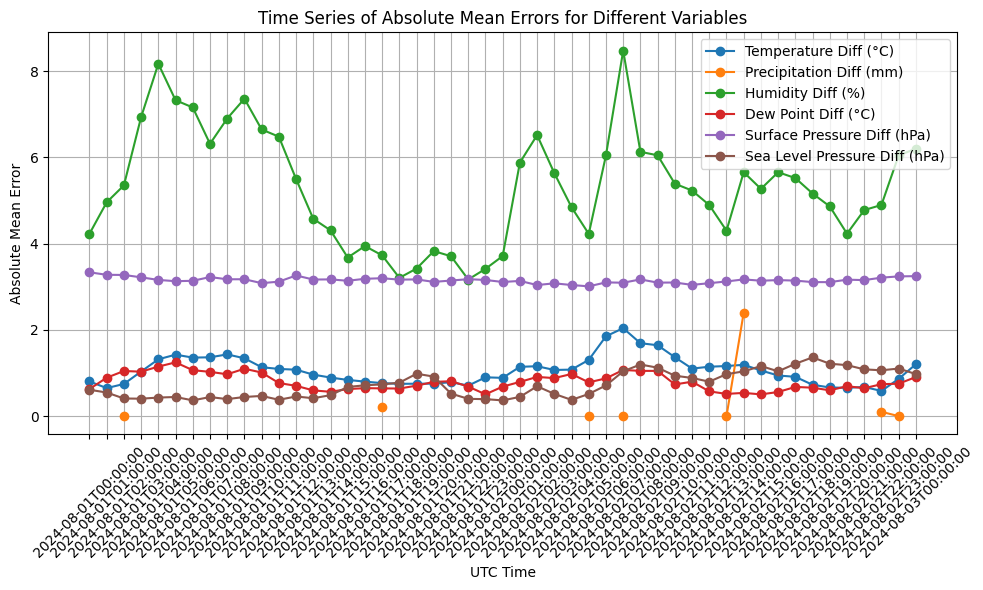

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 각 시간에 대해 변수별로 절댓값 오차의 평균을 계산하는 함수
def calculate_time_series_error(differences_df):
    # 시간별로 데이터를 그룹화
    grouped = differences_df.groupby('time_utc')
    
    # 시간별로 변수들의 절댓값 오차 평균을 계산
    time_series_error = grouped[['temperature_diff', 'precip_diff', 'humidity_diff', 'dewpoint_diff', 'pressure_diff', 'sea_pressure_diff']].apply(lambda x: np.abs(x).mean())
    
    return time_series_error

# 시간별 오차 추이 시각화
def plot_error_trends(time_series_error):
    plt.figure(figsize=(10, 6))
    
    # 각 변수에 대한 시간별 오차를 플롯
    plt.plot(time_series_error.index, time_series_error['temperature_diff'], label='Temperature Diff (°C)', marker='o')
    plt.plot(time_series_error.index, time_series_error['precip_diff'], label='Precipitation Diff (mm)', marker='o')
    plt.plot(time_series_error.index, time_series_error['humidity_diff'], label='Humidity Diff (%)', marker='o')
    plt.plot(time_series_error.index, time_series_error['dewpoint_diff'], label='Dew Point Diff (°C)', marker='o')
    plt.plot(time_series_error.index, time_series_error['pressure_diff'], label='Surface Pressure Diff (hPa)', marker='o')
    plt.plot(time_series_error.index, time_series_error['sea_pressure_diff'], label='Sea Level Pressure Diff (hPa)', marker='o')
    
    # 그래프 레이블 및 타이틀 설정
    plt.xlabel('UTC Time')
    plt.ylabel('Absolute Mean Error')
    plt.title('Time Series of Absolute Mean Errors for Different Variables')
    plt.xticks(rotation=45)  # 시간축 라벨 회전
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # 그래프 출력
    plt.show()

# 오차 계산 후, 시간별로 오차 추이를 계산
time_series_error = calculate_time_series_error(differences_df)

# 오차 추이 시각화
plot_error_trends(time_series_error)


# 온도 변화 동적으로 확인하기

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

plt.switch_backend('TkAgg')

def slider_temperature_average(ds, start_time, end_time, time_interval, unit='K'):
    """
    슬라이더로 시간 간격마다 각 좌표에서의 평균 온도 변화를 동적으로 조정할 수 있는 함수.
    
    Parameters:
    ds (xarray.Dataset): 기후 데이터셋
    start_time (str): 시작 시간 (예: '2024-10-01T00:00:00')
    end_time (str): 끝 시간 (예: '2024-10-03T00:00:00')
    time_interval (int): 시간 간격 (시간 단위, 예: 1은 1시간 간격)
    unit (str): 온도 단위 ('K' for Kelvin, 'C' for Celsius, 'F' for Fahrenheit)
    
    Returns:
    None: 슬라이더를 통해 동적 시각화를 제공함.
    """
    # 1. 시간 범위 내의 데이터 필터링
    time_filtered_ds = ds.sel(time=slice(start_time, end_time))
    
    # 2. 시간 간격으로 나눈 평균 데이터 계산 (온도 단위에 맞게 변환)
    time_steps = time_filtered_ds['time']
    num_steps = len(time_steps)
    
    averaged_temps = []
    averaged_times = []
    
    for i in range(0, num_steps, time_interval):
        if i + time_interval <= num_steps:
            # 기본 데이터는 켈빈(K)
            avg_temp = time_filtered_ds['TMP_1_5maboveground'].isel(time=slice(i, i + time_interval)).mean(dim='time').data
            
            # 단위 변환
            if unit == 'C':  # 켈빈 -> 섭씨
                avg_temp = avg_temp - 273.15
            elif unit == 'F':  # 켈빈 -> 화씨
                avg_temp = (avg_temp - 273.15) * 9/5 + 32
            
            averaged_temps.append(avg_temp)
            start_time = time_steps[i].values
            end_time = time_steps[i + time_interval].values
            averaged_times.append((start_time, end_time))

    # 3. 경도와 위도 데이터 추출
    lat = ds['latitude'][:].data
    lon = ds['longitude'][:].data

    # 4. 그래프 초기 설정
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.subplots_adjust(left=0.1, bottom=0.25)  # 슬라이더를 위한 공간 확보
    
    # 첫 번째 프레임을 시각화 (단위에 맞는 변환된 데이터를 사용)
    temp_plot = ax.pcolormesh(lon, lat, averaged_temps[0], cmap='jet', shading='auto')
    cbar = fig.colorbar(temp_plot)

    # 온도 단위에 따른 레이블 설정
    if unit == 'K':
        cbar.set_label('Temperature (K)')
    elif unit == 'C':
        cbar.set_label('Temperature (°C)')
    elif unit == 'F':
        cbar.set_label('Temperature (°F)')

    # 타이틀에 시간 정보 추가
    start_time, end_time = averaged_times[0]
    title = ax.set_title(f'Average Temperature from {str(start_time)} to {str(end_time)}')

    # 5. 슬라이더 생성 (프레임을 조정)
    ax_slider = plt.axes([0.1, 0.1, 0.8, 0.03], facecolor='lightgoldenrodyellow')
    slider = Slider(ax_slider, 'Time Step', 0, len(averaged_temps) - 1, valinit=0, valstep=1)

    # 6. 슬라이더 업데이트 함수
    def update(val):
        frame = int(slider.val)

        # 이전 플롯 삭제
        while ax.collections:
            ax.collections[0].remove()

        # 새로운 데이터를 pcolormesh로 업데이트
        temp_plot = ax.pcolormesh(lon, lat, averaged_temps[frame], cmap='jet', shading='auto')

        # 타이틀 업데이트
        start_time, end_time = averaged_times[frame]
        ax.set_title(f'Average Temperature from {str(start_time)} to {str(end_time)}')

        # 다시 그리기
        fig.canvas.draw_idle()

    # 7. 슬라이더 이벤트 연결
    slider.on_changed(update)

    # 8. 그래프 출력
    plt.show()

# 함수 사용 예시
slider_temperature_average(ds, '2024-08-01T00:00:00', '2024-08-03T00:00:00', 3, unit='C')


C:\Users\kyuji\AppData\Local\Temp\ipykernel_5356\3323525292.py:56: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  temp_plot = ax.pcolormesh(lon, lat, averaged_temps[0], cmap='jet', shading='auto')
C:\Users\kyuji\AppData\Local\Temp\ipykernel_5356\3323525292.py:84: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  temp_plot = ax.pcolormesh(lon, lat, averaged_temps[frame], cmap='jet', shading='auto')


# 온도와 다른 변수들 간의 상관관계 계산하기

In [26]:
import xarray as xr
import pandas as pd

def calculate_and_print_correlations(ds, mean_dim='time'):
    """
    선택한 축에 따라 평균을 낸 후, 온도와 다른 변수들 간의 상관계수를 계산하고 출력하는 함수.
    
    Parameters:
    ds (xarray.Dataset): 기후 데이터셋
    mean_dim (str): 'time' 또는 'space' 선택 ('time'이면 시간축에 대해 평균, 'space'이면 공간축(y, x)에 대해 평균)
    
    Returns:
    correlations (dict): 변수 이름과 해당 변수의 상관계수를 저장한 딕셔너리
    """
    
    # 1. 선택된 축에 따라 평균 계산
    if mean_dim == 'time':
        # 시간축에 대해 평균 계산
        ds_mean = ds.mean(dim='time', keep_attrs=True)
    elif mean_dim == 'space':
        # 공간축 (y, x)에 대해 평균 계산
        ds_mean = ds.mean(dim=['y', 'x'], keep_attrs=True)
    else:
        raise ValueError("mean_dim은 'time' 또는 'space'만 가능합니다.")
    
    # 2. 온도 변수 선택 (예시: TMP_1_5maboveground)
    temperature = ds_mean['TMP_1_5maboveground']

    # 3. 다른 변수들 선택
    other_vars = [var for var in ds_mean.data_vars if var != 'TMP_1_5maboveground']

    # 4. 온도와 다른 변수들 간의 상관계수 계산
    correlations = {}
    
    for var_name in other_vars:
        # 각 변수 선택
        other_var = ds_mean[var_name]
        
        # 데이터가 시간에 따른 평균이 되었거나, 공간에 따른 평균이 된 경우에 맞춰 데이터를 펼침
        df = pd.DataFrame({
            'Temperature': temperature.values.flatten(),
            var_name: other_var.values.flatten()
        })
        
        # 상관계수 계산 (피어슨 상관계수 사용)
        correlation = df.corr().iloc[0, 1]  # 온도와 해당 변수 간의 상관계수 추출
        correlations[var_name] = correlation

    # 5. 상관계수 출력 (short name과 long name을 함께 출력)
    for var, corr in correlations.items():
        short_name = ds[var].attrs.get('short_name', var)  # short_name 속성 가져오기, 없으면 var 사용
        long_name = ds[var].attrs.get('long_name', 'No long name')  # long_name 가져오기
        print(f'온도와 {short_name} ({long_name}) 변수의 상관계수: {corr:.3f}')
    
    return correlations

# 함수 사용 예시: mean_dim (str): 'time' 또는 'space' 선택
correlations = calculate_and_print_correlations(ds, mean_dim='time')

온도와 NDNSW_surface (NET DOWN SURFACE SW FLUX) 변수의 상관계수: 0.526
온도와 NCPCP_surface (Large-Scale Precipitation (non-convective)) 변수의 상관계수: -0.314
온도와 SNOL_surface (Large-Scale Snow) 변수의 상관계수: nan
온도와 UGRD_10maboveground (U-Component of Wind) 변수의 상관계수: 0.337
온도와 VGRD_10maboveground (V-Component of Wind) 변수의 상관계수: 0.125
온도와 TMIN_1_5maboveground (Minimum Temperature) 변수의 상관계수: 0.998
온도와 TMAX_1_5maboveground (Maximum Temperature) 변수의 상관계수: 0.998
온도와 SPFH_1_5maboveground (Specific Humidity) 변수의 상관계수: 0.837
온도와 RH_1_5maboveground (Relative Humidity) 변수의 상관계수: -0.433
온도와 VIS_1_5maboveground (Visibility) 변수의 상관계수: -0.059
온도와 DPT_1_5maboveground (Dew Point Temperature) 변수의 상관계수: 0.819
온도와 MAXGUST_0maboveground (Maximum Wind Speed) 변수의 상관계수: -0.083
온도와 LCDC_entireatmosphere_consideredasasinglelayer_ (Low Cloud Cover) 변수의 상관계수: -0.226
온도와 MCDC_entireatmosphere_consideredasasinglelayer_ (Medium Cloud Cover) 변수의 상관계수: -0.650
온도와 HCDC_entireatmosphere_consideredasasinglelayer_ (High Cloud Cover) 변수의 상관계수

# 표면 기압을 통해 Land Sea Mask 만들기

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def plot_high_pressure_areas(ds, start_time, end_time, pressure_threshold=100000):
    """
    시작 시간과 끝나는 시간 동안의 평균 표면 압력이 주어진 임계값 이상인 부분만 색깔로 칠해 보여주는 함수.
    
    Parameters:
    ds (xarray.Dataset): 기후 데이터셋
    start_time (str): 시작 시간 (예: '2024-10-01T00:00:00')
    end_time (str): 끝나는 시간 (예: '2024-10-02T00:00:00')
    pressure_threshold (float): 압력 임계값 (기본값: 100700 Pa, 즉 1007 hPa)
    
    Returns:
    None: 지정된 시간 동안의 평균 표면 압력에 대해 시각화 결과를 보여줌.
    """
    
    # 1. 입력된 시간 범위에 대한 표면 압력 데이터 선택 및 평균 계산
    pres_at_time = ds['PRES_surface'].sel(time=slice(start_time, end_time)).mean(dim='time')
    
    # 2. 압력이 임계값 이상인 부분을 마스크 처리
    mask = pres_at_time >= pressure_threshold
    
    # 3. 경도와 위도 데이터 추출
    lon = ds['longitude'].values
    lat = ds['latitude'].values
    
    # 4. 그래프 설정
    plt.figure(figsize=(10, 6))
    plt.contourf(lon, lat, np.where(mask, pres_at_time, np.nan), cmap='coolwarm')
    plt.colorbar(label='Surface Pressure (Pa)')
    
    # 5. 타이틀 및 축 설정
    plt.title(f'Areas with Surface Pressure >= {pressure_threshold/100} hPa from {start_time} to {end_time}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    # 6. 그래프 출력
    plt.show()

# 함수 사용 예시:
plot_high_pressure_areas(ds, '2024-08-01T00:00:00', '2024-08-02T00:00:00')


# 지면, 수면 데이터 따로 분리해서 상관계수 구하기

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def create_land_sea_mask(ds, pressure_threshold=100000):
    """
    시간축에 대해 평균을 낸 후 공간축을 기준으로 지면과 수면을 구분하는 마스크를 생성하는 함수.
    
    Parameters:
    ds (xarray.Dataset): 기후 데이터셋
    pressure_threshold (float): 압력 임계값 (기본값: 100000 Pa, 즉 1000 hPa)
    
    Returns:
    land_mask (xarray.DataArray): 지면 마스크 (True는 지면, False는 수면)
    sea_mask (xarray.DataArray): 수면 마스크 (True는 수면, False는 지면)
    """
    # 1. 시간 축에 대해 PRES_surface의 평균을 계산
    pres_surface_mean = ds['PRES_surface'].mean(dim='time')
    
    # 2. 평균값을 기준으로 지면/수면 마스크 생성
    land_mask = pres_surface_mean < pressure_threshold  # 지면: 압력이 threshold 미만인 부분
    sea_mask = pres_surface_mean >= pressure_threshold  # 수면: 압력이 threshold 이상인 부분
    
    return land_mask, sea_mask

def filter_data_by_mask(ds, land_mask, sea_mask):
    """
    지면과 수면 마스크를 이용해 각 좌표의 데이터를 필터링하여 반환하는 함수.
    
    Parameters:
    ds (xarray.Dataset): 기후 데이터셋
    land_mask (xarray.DataArray): 지면 마스크
    sea_mask (xarray.DataArray): 수면 마스크
    
    Returns:
    land_data (dict): 지면에 해당하는 좌표들의 데이터
    sea_data (dict): 수면에 해당하는 좌표들의 데이터
    """
    
    land_data = {}
    sea_data = {}
    
    for var_name in ds.data_vars:
        # 지면과 수면 마스크 적용
        land_data[var_name] = ds[var_name].where(land_mask, drop=True)
        sea_data[var_name] = ds[var_name].where(sea_mask, drop=True)
    
    return land_data, sea_data

def calculate_correlations(data_dict, reference_var='TMP_1_5maboveground'):
    """
    주어진 데이터셋에 대해 각 변수와 온도(TMP_1_5maboveground) 간의 상관계수를 계산하는 함수.
    
    Parameters:
    data_dict (dict): 변수별로 필터링된 데이터
    reference_var (str): 기준이 되는 변수 (기본값: 'TMP_1_5maboveground')
    
    Returns:
    correlations (dict): 변수별 상관계수
    """
    correlations = {}
    temperature = data_dict[reference_var]
    
    for var_name, var_data in data_dict.items():
        if var_name == reference_var:
            continue
        
        # NaN 값 제거 후 상관계수 계산
        df = pd.DataFrame({
            'Temperature': temperature.values.flatten(),
            var_name: var_data.values.flatten()
        }).dropna()  # NaN 제거
        
        # 상관계수를 계산할 데이터가 충분한지 확인
        if not df.empty and len(df) > 1:  # 데이터가 적어도 2개 이상 있어야 상관계수 계산 가능
            correlations[var_name] = df.corr().iloc[0, 1]
        else:
            correlations[var_name] = None  # 데이터가 부족한 경우 None 반환
    
    return correlations

def print_correlations(ds, correlations):
    """
    상관계수를 출력할 때 short name과 long name을 함께 출력하는 함수.
    
    Parameters:
    ds (xarray.Dataset): 기후 데이터셋
    correlations (dict): 변수별 상관계수
    
    Returns:
    None: 상관계수와 변수의 short name, long name을 함께 출력
    """
    for var_name, corr in correlations.items():
        short_name = ds[var_name].attrs.get('short_name', var_name)
        long_name = ds[var_name].attrs.get('long_name', 'No long name')
        
        if corr is not None:
            print(f"{short_name} ({long_name})와 온도의 상관계수: {corr:.3f}")
        else:
            print(f"{short_name} ({long_name}) 데이터가 부족해 상관계수를 계산할 수 없습니다.")

# 함수 사용 예시:
# 1. 데이터셋에서 시간축에 대해 평균을 내고, land/sea mask 생성
land_mask, sea_mask = create_land_sea_mask(ds, pressure_threshold=100000)

# 2. 지면과 수면에 해당하는 데이터를 필터링
land_data, sea_data = filter_data_by_mask(ds, land_mask, sea_mask)

# 3. 지면과 수면 각각의 상관계수를 계산
land_correlations = calculate_correlations(land_data)
sea_correlations = calculate_correlations(sea_data)

# 4. 결과 출력
print("지면 상관계수:")
print_correlations(ds, land_correlations)

print("\n수면 상관계수:")
print_correlations(ds, sea_correlations)


지면 상관계수:
NDNSW_surface (NET DOWN SURFACE SW FLUX)와 온도의 상관계수: 0.600
NCPCP_surface (Large-Scale Precipitation (non-convective))와 온도의 상관계수: -0.103
SNOL_surface (Large-Scale Snow)와 온도의 상관계수: nan
UGRD_10maboveground (U-Component of Wind)와 온도의 상관계수: 0.169
VGRD_10maboveground (V-Component of Wind)와 온도의 상관계수: 0.114
TMIN_1_5maboveground (Minimum Temperature)와 온도의 상관계수: 0.990
TMAX_1_5maboveground (Maximum Temperature)와 온도의 상관계수: 0.990
SPFH_1_5maboveground (Specific Humidity)와 온도의 상관계수: 0.647
RH_1_5maboveground (Relative Humidity)와 온도의 상관계수: -0.689
VIS_1_5maboveground (Visibility)와 온도의 상관계수: -0.035
DPT_1_5maboveground (Dew Point Temperature)와 온도의 상관계수: 0.686
MAXGUST_0maboveground (Maximum Wind Speed)와 온도의 상관계수: 0.189
LCDC_entireatmosphere_consideredasasinglelayer_ (Low Cloud Cover)와 온도의 상관계수: -0.183
MCDC_entireatmosphere_consideredasasinglelayer_ (Medium Cloud Cover)와 온도의 상관계수: -0.265
HCDC_entireatmosphere_consideredasasinglelayer_ (High Cloud Cover)와 온도의 상관계수: -0.252
TCAR_entireatmosphere_consid